## Convert a boolean expression to an oracle

In [202]:
from qiskit.circuit import ClassicalRegister
from funcs import *

### 1. convert expression to reverse prefix notation

In [203]:
# expression should only contain capital letters or !, (, ), &, separated by spaces
# expression = '! ( ! ( A & B ) ) & ( ! C & D ) & E'
expression = '! ( ! A & B ) & C & ( C & ! E ) & D'
# expression = 'A & B & ! ( C & D )'
# remenber to change 'testvec' after changing 'expression'
testvec = '01101'        # test vector should agree with the expression in the number of variables
# testvec = '0000'

In [204]:
def infixToPostfix(infixexpr):
    prec = {}
    prec["!"] = 3
    prec["&"] = 2
    prec["("] = 1
    oplist = []
    postfixList = []
    tokenList = infixexpr.split()

    for token in tokenList:
        if token in "ABCDEFGHIJKLMNOPQRSTUVWXYZ" or token in "01":
            postfixList.append(token)
        elif token == '(':
            oplist.append(token)
        elif token == ')':
            topToken = oplist.pop()
            while topToken != '(':
                postfixList.append(topToken)
                topToken = oplist.pop()
        else:
            while (len(oplist)>0) and \
               (prec[oplist[-1]] >= prec[token]):
                  postfixList.append(oplist.pop())
            oplist.append(token)

    while len(oplist) > 0:
        postfixList.append(oplist.pop())
    return " ".join(postfixList)

rpn = infixToPostfix(expression)
rpnlst = rpn.split()
print(rpnlst)

['A', '!', 'B', '&', '!', 'C', '&', 'C', 'E', '!', '&', '&', 'D', '&']


### 2.Convert RPN to qiskit instructions

In [205]:
qubit_dict = {}
not_dict = {}
flag = 0
for ch in rpnlst:
    if ch.isalpha() and ch not in qubit_dict:
        qubit_dict[ch] = flag
        not_dict[flag] = 0
        flag += 1
qubit_num = flag + rpnlst.count('&')
qc = QuantumCircuit(qubit_num)
flag -= 1

for i in range(flag+1):
    if testvec[i] == '1':
        qc.x(i)
    # qc.h(i)
print(qubit_dict, flag)
print(not_dict)

{'A': 0, 'B': 1, 'C': 2, 'E': 3, 'D': 4} 4
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0}


In [206]:
operators = ['&', '!']
stack = []
tokens = []
for char in rpnlst:  
    if char.isalpha():  
        tokens.append(qubit_dict[char])  
    elif char in operators:  
        tokens.append(char)  
print(tokens)
for token in tokens: 
    print(token, stack, flag) 
    if token not in operators:
        stack.append(token)
        if (token in not_dict) and (not_dict[token] % 2 == 1):
            qc.x(token)    # if the number of '!' is odd, apply x gate
    elif token == '!':
        qc.x(stack[-1])
        if stack[-1] in not_dict:
            not_dict[stack[-1]] += 1
    elif token == '&':
        flag += 1
        qc.ccx(stack[-2], stack[-1], flag)
        stack.pop()
        stack.pop()
        stack.append(flag)
print(token, stack, flag) 

[0, '!', 1, '&', '!', 2, '&', 2, 3, '!', '&', '&', 4, '&']
0 [] 4
! [0] 4
1 [0] 4
& [0, 1] 4
! [5] 5
2 [5] 5
& [5, 2] 5
2 [6] 6
3 [6, 2] 6
! [6, 2, 3] 6
& [6, 2, 3] 6
& [6, 7] 7
4 [8] 8
& [8, 4] 8
& [9] 9


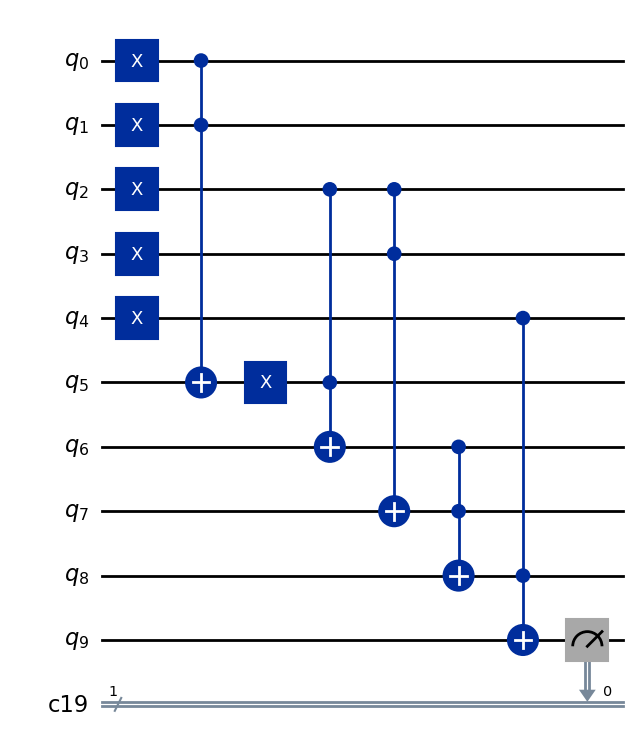

In [207]:
qc = transpile(qc, backend=AerSimulator(), optimization_level=3)
c = ClassicalRegister(1)
qc.add_register(c)
qc.measure(flag, c[0])
qc.draw(output='mpl')

In [208]:
print('original expression: ', expression)
print('qubit_index: ', qubit_dict)
print('initialize: ', testvec)
val_expr = ''
for ch in expression:
    if ch in qubit_dict:
        val_expr += testvec[qubit_dict[ch]]
    else:
        val_expr += ch
print('val_expr: ', val_expr)
results = execute_qc(qc)
print('result: ', results)


original expression:  ! ( ! A & B ) & C & ( C & ! E ) & D
qubit_index:  {'A': 0, 'B': 1, 'C': 2, 'E': 3, 'D': 4}
initialize:  01101
val_expr:  ! ( ! 0 & 1 ) & 1 & ( 1 & ! 0 ) & 1
result:  {'0': 1024}
